<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fsc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Build intuition for Fourier Shell Correlation

# Resources


# Setup
The functions below are explained in the 2D class notebook (`2d_class_fourier.ipynb`).

In [34]:
%%bash
pip install pyFFTW
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/ctf.py
sed 's/fftfreqs/fftfreq/' ctf.py > ctf_fix.py # this is for some numpy version fix
mv ctf_fix.py ctf.py

--2020-06-22 15:16:38--  https://raw.githubusercontent.com/asarnow/pyem/master/pyem/ctf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4643 (4.5K) [text/plain]
Saving to: ‘ctf.py.1’

     0K ....                                                  100% 31.1M=0s

2020-06-22 15:16:38 (31.1 MB/s) - ‘ctf.py.1’ saved [4643/4643]



In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mrc
import ctf
import pyfftw
import pyfftw.interfaces.numpy_fft
from numba import jit

In [ ]:
%%bash
wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-9243/map/emd_9243.map.gz
gunzip emd_9243.map.gz

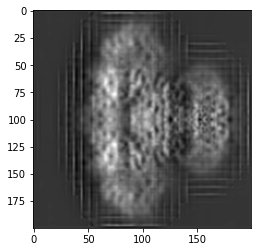

In [71]:
fname = 'emd_9243.map'#'/content/drive/My Drive/repos/learn_cryoem_math/data/ouhn_Data1_P1/emd_9243_downsample_64pix.mrc'#emd_9243_downsample_128pix_lp3A.mrc.mrc'#'emd_9243.map'
vol = mrc.read(fname)
psize_A = 1.26
image_2d = vol.mean(0)
nx = image_2d.shape[0]
do_2dplot(image_2d)

First let's simulate some data. We can change the noise, defocus, and rotation to see the effect of these on the fsc.

## 2D Functions

In [6]:
from scipy.ndimage.interpolation import rotate


def fft2d(arr2d,mode,numpy_fft=pyfftw.interfaces.numpy_fft):
  '''
  we apply an alterating +1/-1 multiplicative before we go to/from Fourier space. 
  Later we apply this again to the transform.
  '''
  assert arr2d.ndim == 2
  n1,n2 = arr2d.shape
  assert n1==n2
  arr2d = neg_pos(arr2d.copy())
  if mode=='f':
    arr2d_f = numpy_fft.fftn(arr2d.reshape(-1,n1,n1),axes=(-2,-1))
    arr2d_f /= n1
  elif mode=='i':
    arr2d_f = numpy_fft.ifftn(arr2d.reshape(-1,n1,n1),axes=(-2,-1)).real
    arr2d_f *= n1
  
  arr2d_f = neg_pos(arr2d_f.reshape(n1,n1).copy())
  return(arr2d_f)

def do_fft(arr2d,**kwargs):
  return(fft2d(arr2d,mode='f',**kwargs))

def do_ifft(arr2d,**kwargs):
  return(fft2d(arr2d,mode='i',**kwargs))

@jit
def neg_pos(arr2d):
  '''
  each pixel switches from positive to negative in checker board pattern
  '''
  assert arr2d.ndim == 2
  for r in range(arr2d.shape[0]):
    for c in range(arr2d.shape[1]):
      if (r+c)%2:
        arr2d[r,c] *= -1
  return(arr2d)

def do_2dplot(arr):
  plt.imshow(arr, cmap='gray')

def do_1dplot(arr,idx=None,**kwargs):
  sr = pd.Series(arr)
  if idx is not None: sr.index=idx
  sr.plot(**kwargs)

def log_abs(arr):
  return(np.log(1+np.abs(arr)))


def do_complex_rotate(arr,angle,rotate_func=rotate, **kwargs):
  r = rotate(np.real(arr),angle=angle, reshape=False, **kwargs)
  i = rotate(np.imag(arr),angle=angle, reshape=False, **kwargs)
  return(r+i*1j)



In [210]:
def simulate_data(image_2d,psize_A,N_particles=500,apply_ctf=True,df_low=1e4,df_high=2e4,angle_low=0,angle_high=360,snr=3,bool_circle_mask=None):
  assert image_2d.ndim == 2
  nx = image_2d.shape[0]
  image_2d_f = do_fft(image_2d) # ground truth image

  true_angles = np.random.uniform(low=angle_low,high=angle_high,size=N_particles)

  ctf_2ds = np.zeros((N_particles,nx,nx))
  dfs = np.random.uniform(low=df_low,high=df_high,size=N_particles)
  s, a = ctf.ctf_freqs(image_2d.shape,d=1/psize_A)

  noise_std = image_2d_f.std() / snr

  images_observed = np.zeros((N_particles,nx,nx), dtype=np.complex64)

  sim_params_d = defaultdict(list)

  for i in range(N_particles):
    # rotate
    image_2d_f_rot = do_complex_rotate(image_2d_f,angle=true_angles[i])
    if bool_circle_mask is not None:
      image_2d_f_rot[bool_circle_mask]=0
    # ctf
    if apply_ctf:
      ctf_2ds[i,:,:] = np.fft.fftshift(ctf.eval_ctf(s, a, def1=dfs[i], def2=dfs[i], angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=0))
      image_2d_f_rot *= ctf_2ds[i]
    else:
      dfs = np.nan
    # noise
    noise = np.random.normal(loc=0,scale=noise_std,size=nx*nx).reshape(nx,nx)
    images_observed[i,:,:] = image_2d_f_rot + noise

  sim_params_df = pd.DataFrame({'df1':dfs,'df2':dfs, 'pose2D':true_angles})
  return(images_observed,sim_params_df)


images_observed,sim_params_df = simulate_data(image_2d,psize_A,apply_ctf=True,N_particles=500,df_low=1e4,df_high=2e4,angle_low=0, angle_high=0)



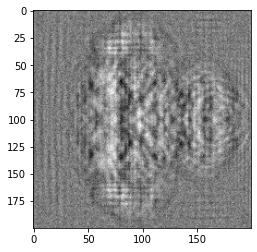

In [211]:
do_2dplot(do_ifft(images_observed[0]))

In [213]:
sim_params_df.sort_values('df1')

,df1,df2,pose2D
171,10023.123791,10023.123791,0.0
95,10089.405724,10089.405724,0.0
337,10100.561046,10100.561046,0.0
304,10139.167879,10139.167879,0.0
210,10140.696752,10140.696752,0.0
...,...,...,...
79,19833.485846,19833.485846,0.0
219,19864.384443,19864.384443,0.0
184,19886.700929,19886.700929,0.0
188,19923.575887,19923.575887,0.0


# 2D Fourier Ring Correlation
* We can compute Fourier Ring Correlation, as in Fig 3 and 4 of `Sigworth, F. J. (1998). A Maximum-Likelihood Approach to Single-Particle Image Refinement. Journal of Structural Biology, 122(3), 328–339. http://doi.org/10.1006/jsbi.1998.4014`

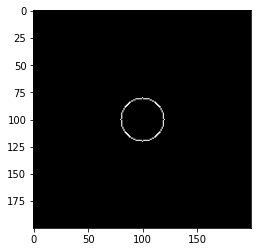

In [87]:
def cmask(index,radius,array,do_ring=False,ring_thickness=1):
  '''
  make a binary circular mask, or ring (variable thickness). 
  '''
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  xxyy = x*x + y*y
  mask = xxyy <= radius*radius
  if do_ring:
    mask_outer = mask
    mask_inner = xxyy <= (radius-ring_thickness)*(radius-ring_thickness)
    mask = np.logical_xor(mask_outer,mask_inner)
  return(mask)
r_high=20
ring_mask = cmask(index=(nx//2,nx//2),radius=r_high,array=np.ones_like(image_2d), do_ring=True, ring_thickness=1).astype(np.bool)
do_2dplot(ring_mask)

In [223]:
def xnorm(arrA_complex,arrB_complex):
  return(np.multiply(arrA_complex, np.conjugate(arrB_complex)).sum())

def fsc_kernel(half_map_A,half_map_B,mask):
  '''
  the mask selects out indeces to be summed over
  this computes a number
  the real part can be taken (same as averaging AB and BA)
  '''
  upstairs = xnorm(half_map_A[mask],half_map_B[mask])
  downstairs = np.linalg.norm(half_map_A[mask])
  downstairs *= np.linalg.norm(half_map_B[mask])
  fsc = upstairs / downstairs
  return(fsc)

def fsc_2d(half_map_A,half_map_B,radius_step):
  '''
  https://en.wikipedia.org/wiki/Fourier_shell_correlation
  testing shows that a ring thickness of more than one smoothes things out
  '''
  ring_thickness=radius_step
  radii = range(1,nx//2,ring_thickness)
  fsc_2ds = np.empty(len(radii), dtype=np.complex64)
  for i,rad_high in enumerate(radii):
    if rad_high - ring_thickness >=0:
      ring_mask = cmask(index=(nx//2,nx//2),radius=rad_high,array=np.ones_like(image_2d), do_ring=True, ring_thickness=ring_thickness).astype(np.bool)
      fsc_2ds[i] = fsc_kernel(half_map_A,half_map_B,ring_mask)
  return(fsc_2ds)


Let's look quickly at things when there is no CTF. We can add the noise in real space, or Fourier space.

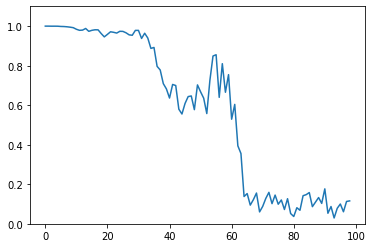

In [216]:
snr=3
noise_std = image_2d.std() / snr
noise = np.random.normal(loc=0,scale=noise_std,size=nx*nx).reshape(nx,nx)

half_map_A, half_map_B = do_fft(image_2d), do_fft(image_2d + noise)
fsc_2ds = fsc_2d(half_map_A, half_map_B, radius_step=1)
pd.Series(fsc_2ds.real).plot(ylim=(0,1.1))


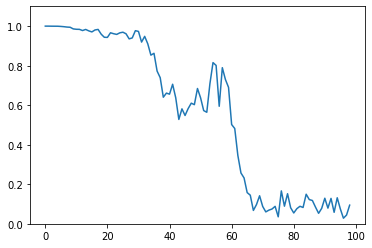

In [220]:
half_map_A = do_fft(image_2d)

snr=3
noise_std = half_map_A.std() / snr
noise = np.random.normal(loc=0,scale=noise_std,size=nx*nx).reshape(nx,nx)

half_map_B = do_fft(image_2d + noise)
fsc_2ds = fsc_2d(half_map_A, half_map_B, radius_step=1)
pd.Series(fsc_2ds.real).plot(ylim=(0,1.1))


We can see that the FSCs are basically the same.

## Effect of noise
Let's add in more noise and see how this effects the FSC. We would expect the FSC to drop off earlier with more noise.

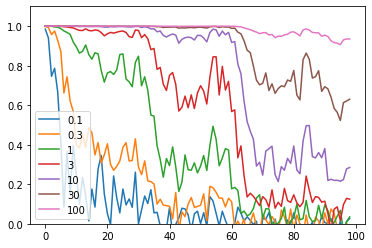

In [237]:
noise_std = image_2d.std()
half_map_A = do_fft(image_2d)
N_av = 1
for snr in [0.1,0.3,1,3,10,30,100]:
  fsc_2ds = np.zeros(nx//2-1, dtype=np.complex128)
  noise = np.random.normal(loc=0,scale=noise_std/snr,size=nx*nx).reshape(nx,nx)
  half_map_B = do_fft(image_2d + noise)
  for average in range(N_av):
    fsc_2ds += fsc_2d(half_map_A, half_map_B, radius_step=1)
  fsc_2ds /= N_av
  pd.Series(fsc_2ds.real).plot(ylim=(0,1.1),legend=True, label=snr)


The FSC is noisy and goes up and then down. Is this noise, or some general trend? We can average over trials of random noise to investigate.

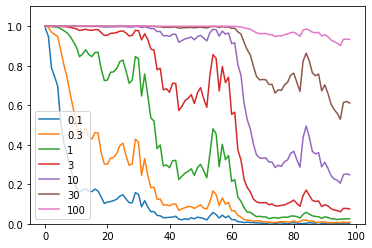

In [239]:
noise_std = image_2d.std()
half_map_A = do_fft(image_2d)
N_av = 500
for snr in [0.1,0.3,1,3,10,30,100]:
  fsc_2ds = np.zeros(nx//2-1, dtype=np.complex128)
  for average in range(N_av):
    noise = np.random.normal(loc=0,scale=noise_std/snr,size=nx*nx).reshape(nx,nx)
    half_map_B = do_fft(image_2d + noise)
    fsc_2ds += fsc_2d(half_map_A, half_map_B, radius_step=1)
  fsc_2ds /= N_av
  pd.Series(fsc_2ds.real).plot(ylim=(0,1.1),legend=True, label=snr)


In general we can see that the FSC drops off earlier, and that the FSC drops, and does sometimes rise.

## Effect of defocus
We can generate fake data at given defocus values, and see what the effect of defocus is on the FSC. 

In [267]:
images_observed_f,sim_params_df = simulate_data(image_2d,psize_A,apply_ctf=True,N_particles=5,df_low=1e4,df_high=2e4,angle_low=0, angle_high=0,
                                              snr=10)

sim_params_df = sim_params_df.sort_values('df1')

In [268]:
sim_params_df

,df1,df2,pose2D
2,12823.294909,12823.294909,0.0
1,14244.484855,14244.484855,0.0
4,17261.942519,17261.942519,0.0
0,18716.188285,18716.188285,0.0
3,18882.572154,18882.572154,0.0


In [262]:
mid_df = sim_params_df.iloc[0].name
[1,2,3,4,5][mid_df]

5

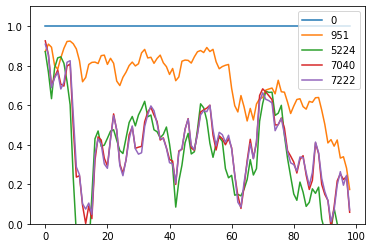

In [263]:
min_df = sim_params_df.iloc[0].name
for idx in  sim_params_df.index:
  half_map_A, half_map_B = do_fft(images_observed_f[mid_df]), do_fft(images_observed_f[idx])
  fsc_2ds = fsc_2d(half_map_A, half_map_B, radius_step=1)
  df_diff = sim_params_df.loc[idx]['df1'] - sim_params_df.loc[min_df]['df1']
  pd.Series(fsc_2ds.real).plot(ylim=(0,1.1), legend=True, 
                               label='%i' % df_diff)

As expected, the FSC drops as the defocus difference increases. The FSC dramatically drops to zero very early, so defocus has pronounced effects at low resolution details.

## Effect of rotation.
We can rotate the particles, and study the effect on the FSC

In [280]:
df=1e4
images_observed_f,sim_params_df = simulate_data(image_2d,psize_A,apply_ctf=True,N_particles=5,
                                                df_low=df,df_high=df,
                                                angle_low=0, angle_high=10,
                                              snr=10)

sim_params_df = sim_params_df.sort_values('pose2D')
sim_params_df

,df1,df2,pose2D
1,10000.0,10000.0,2.706149
3,10000.0,10000.0,3.064851
4,10000.0,10000.0,4.156997
2,10000.0,10000.0,5.321569
0,10000.0,10000.0,6.150878


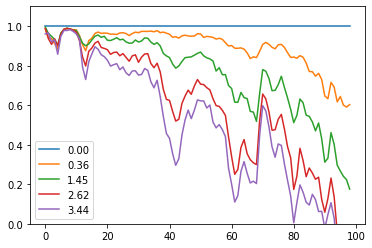

In [281]:
min_angle = sim_params_df.iloc[0].name
for idx in  sim_params_df.index:
  half_map_A, half_map_B = do_fft(images_observed_f[min_angle]), do_fft(images_observed_f[idx])
  fsc_2ds = fsc_2d(half_map_A, half_map_B, radius_step=1)
  df_diff = sim_params_df.loc[idx]['pose2D'] - sim_params_df.loc[min_angle]['pose2D']
  pd.Series(fsc_2ds.real).plot(ylim=(0,1.1), legend=True, 
                               label='%.2f' % df_diff)

We see that the FSC is very sensitive to angle. Just a few degrees and it drops off dramatically.

# 3D Fourier Shell Correlation
The 2D FSC is a simplified version of the 3D version. The S in FSC stands for shell, which is a ring in the 2D case.

To do this in Fourier space requires 3D FFTs

## 3D masking (shells)

In [344]:
def cmask(index,radius,array,do_shell=False,shell_thickness=1):
  '''
  make a binary circular mask, or ring (variable thickness). 
  '''
  a,b,c = index
  nx0,nx1,nx2 = array.shape
  x0,x1,x2 = np.ogrid[-a:nx0-a,-b:nx1-b,-c:nx1-c]
  r2 = x0*x0+x1*x1+x2*x2
  mask = r2 <= radius*radius
  if do_shell:
    mask_outer = mask
    mask_inner = r2 <= (radius-shell_thickness)*(radius-shell_thickness)
    mask = np.logical_xor(mask_outer,mask_inner)
  return(mask)
r_high=100
shell_mask = cmask(index=(nx//2,nx//2,nx//2),radius=r_high,array=np.ones_like(vol), do_shell=True, shell_thickness=1).astype(np.bool)



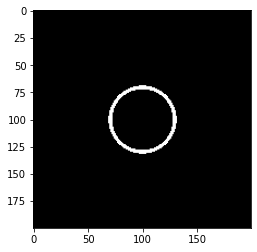

In [323]:
do_2dplot(shell_mask[5])


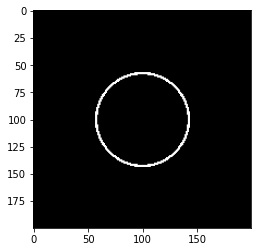

In [322]:
do_2dplot(shell_mask[10])


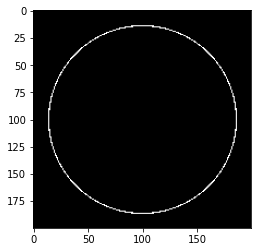

In [335]:
do_2dplot(shell_mask[50])

If we move through the shell, we can see slices of the rings.
* slices near the edge of the shell are thicker
* the slices change slower when they are larger (as expected, because the slope in the slice direction is smaller)

## 3D FFT

Let's take an FFT and look at a slice of it. The Fourier slice theorem tells us how to connect a 2d projection to a slice of the 3D Fourier Transform. But that's a story for another notebook. 

In [337]:
@jit
def neg_pos3(arr3d):
  '''
  each pixel switches from positive to negative in checker board pattern
  '''
  assert arr3d.ndim == 3
  for x0 in range(arr3d.shape[0]):
    for x1 in range(arr3d.shape[1]):
      for x2 in range(arr3d.shape[2]):
        if (x0+x1+x2)%2:
          arr3d[x0,x1,x2] *= -1
  return(arr3d)
  
def do_fft3d(arr3d,mode,numpy_fft=pyfftw.interfaces.numpy_fft):
  '''
  we apply an alterating +1/-1 multiplicative before we go to/from Fourier space. 
  Later we apply this again to the transform.
  '''
  assert arr3d.ndim == 3
  n1,n2,n3 = arr3d.shape
  assert n1==n2 and n2==n3
  arr3d = neg_pos3(arr3d.copy())
  norm = np.sqrt(n1**3)
  if n1 % 4 != 0:
    norm *= -1
  if mode=='f':
    arr3d_f = numpy_fft.fftn(arr3d)
    arr3d_f /= norm
  elif mode=='i':
    arr3d_f = numpy_fft.irfftn(arr3d)
    arr3d_f *= norm
  
  arr3d_f = neg_pos3(arr3d_f.reshape(n1,n1,n1).copy())
  return(arr3d_f)

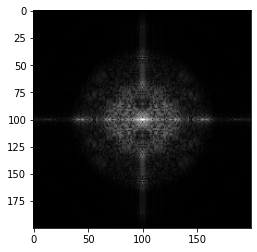

In [300]:
vol_f = do_fft3d(vol,'f')
do_2dplot(log_abs(vol_f[100]))

## FSC
Now let's compute the effect of noise on the FSC.

In [356]:
def fsc_3d(half_map_A,half_map_B,shell_thickness=1):
  '''
  https://en.wikipedia.org/wiki/Fourier_shell_correlation
  testing shows that a ring thickness of more than one smoothes things out
  '''
  radii = range(1,nx//2,shell_thickness)
  fsc_3ds = np.empty(len(radii), dtype=np.complex64)
  for i,rad_high in enumerate(radii):
    if rad_high - ring_thickness >=0:
      shell_mask = cmask(index=(nx//2,nx//2,nx//2),radius=rad_high,array=np.ones_like(vol), do_shell=True, shell_thickness=shell_thickness).astype(np.bool)
      fsc_3ds[i] = fsc_kernel(half_map_A,half_map_B,shell_mask)
  return(fsc_3ds)

In [352]:
half_map_A = do_fft3d(vol,'f')
noise_std = half_map_A.std()
snr=1
noise = np.random.normal(loc=0,scale=noise_std / snr,size=nx*nx*nx).reshape(nx,nx,nx)
half_map_B = do_fft3d(vol+noise,'f')

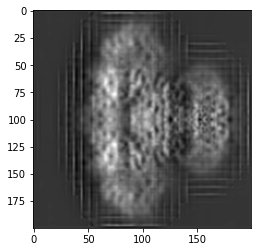

In [350]:
do_2dplot(vol.mean(0))

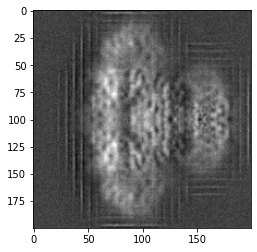

In [353]:
do_2dplot((vol+noise).mean(0))

We can see the grainyness of the noise.

In [357]:
fsc_3ds = fsc_3d(half_map_A,half_map_B)

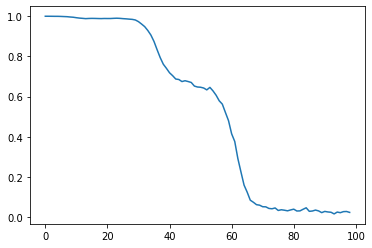

In [360]:
pd.Series(fsc_3ds.real).plot()

The FSC dies off at high resolutions.

# Scratch